In [1]:
### Required imports
import pandas as pd
import zipfile
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # For detailed regression summary

In [2]:
# Define the path to the zip file and the name of the CSV file within the zip
zip_file_path = 'usa-real-estate-dataset.zip'
csv_file_name = 'realtor-data.zip.csv'  # Adjust if the file name inside the zip is different

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # List all files in the zip archive (optional)
    print("Files in zip:", zip_ref.namelist())

    # Read the CSV file into a pandas DataFrame
    with zip_ref.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)
        print(df.head())  # Display the first few rows of the DataFrame

Files in zip: ['realtor-data.zip.csv']
   brokered_by    status     price  bed  bath  acre_lot     street  \
0     103378.0  for_sale  105000.0  3.0   2.0      0.12  1962661.0   
1      52707.0  for_sale   80000.0  4.0   2.0      0.08  1902874.0   
2     103379.0  for_sale   67000.0  2.0   1.0      0.15  1404990.0   
3      31239.0  for_sale  145000.0  4.0   2.0      0.10  1947675.0   
4      34632.0  for_sale   65000.0  6.0   2.0      0.05   331151.0   

         city        state  zip_code  house_size prev_sold_date  
0    Adjuntas  Puerto Rico     601.0       920.0            NaN  
1    Adjuntas  Puerto Rico     601.0      1527.0            NaN  
2  Juana Diaz  Puerto Rico     795.0       748.0            NaN  
3       Ponce  Puerto Rico     731.0      1800.0            NaN  
4    Mayaguez  Puerto Rico     680.0         NaN            NaN  


In [3]:
### Function to clean the data
def clean_data(df):
    df_cleaned = df.copy()
    df_cleaned['status'] = df_cleaned['status'].apply(lambda x: 1 if x == 'for_sale' else 0)
    df_cleaned = df_cleaned[df_cleaned['status'] == 1]

    total_observations = len(df_cleaned)
    print("\nTotal number of observations (rows):", total_observations)
    print("\nMax Missing values in one column:", max(df_cleaned.isnull().sum()))

    df_cleaned.drop(columns=['prev_sold_date'], inplace=True)
    df_cleaned.dropna(inplace=True)
    df_cleaned.drop(columns=['street'], inplace=True)

    total_observations_after = len(df_cleaned)
    print("\nTotal number of observations (rows) After dropping rows with missing values:", total_observations_after)

    print(df_cleaned.head())
    return df_cleaned

### Function to fit Linear Regression models for each state
def fit_state_models(df, features, target):
    state_models = {}
    for state in df['state'].unique():
        print(f"\nFitting Linear Regression model for state: {state}")
        state_df = df[df['state'] == state].copy()
        if len(state_df) < 10:
            print(f"Not enough data for state: {state}")
            continue

        X_state = state_df[features]
        y_state = state_df[target]

        model = LinearRegression(fit_intercept=True)
        model.fit(X_state, y_state)

        state_df['predicted_price'] = model.predict(X_state)

        mse = mean_squared_error(y_state, state_df['predicted_price'])
        r2 = r2_score(y_state, state_df['predicted_price'])

        state_models[state] = {
            'model': model,
            'mse': mse,
            'r2': r2,
            'predicted_prices': state_df[['price', 'predicted_price']]
        }

        print(f"Mean Squared Error for state {state}: {mse}")
        print(f"R-squared for state {state}: {r2}")

    return state_models

### Function to print predicted prices for each state
def print_predicted_prices(state_models):
    for state, results in state_models.items():
        print(f"\nPredicted prices for houses in {state}:")
        print(results['predicted_prices'].head())

### Function to predict price based on specific characteristics
def predict_price(state_models, state, bed, bath, acre_lot, house_size):
    if state not in state_models:
        raise ValueError(f"No model found for state: {state}")

    model = state_models[state]['model']
    input_data = pd.DataFrame({
        'bed': [bed],
        'bath': [bath],
        'acre_lot': [acre_lot],
        'house_size': [house_size]
    })

    predicted_price = model.predict(input_data)
    return predicted_price[0]

### Function to plot predicted prices by state
def plot_predicted_prices_by_state(state_models):
    predicted_prices = []
    states = []
    
    for state, results in state_models.items():
        preds = results['predicted_prices']['predicted_price']
        predicted_prices.extend(preds)
        states.extend([state] * len(preds))
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=states, y=predicted_prices)
    plt.xlabel('State')
    plt.ylabel('Predicted Price')
    plt.title('Predicted Prices by State')
    plt.xticks(rotation=90)
    plt.show()

### Function to plot model performance by state
def plot_model_performance(state_models):
    states = []
    mses = []
    r2s = []
    
    for state, metrics in state_models.items():
        states.append(state)
        mses.append(metrics['mse'])
        r2s.append(metrics['r2'])
    
    plt.figure(figsize=(16, 10))
    
    # MSE bar chart
    plt.subplot(2, 1, 1)
    sns.barplot(x=states, y=mses)
    plt.ylabel('Mean Squared Error')
    plt.title('Model Performance by State - MSE')
    plt.xticks(rotation=45, ha='right')  # Rotate state names and align right
    
    # R² bar chart
    plt.subplot(2, 1, 2)
    sns.barplot(x=states, y=r2s)
    plt.ylabel('R-squared')
    plt.title('Model Performance by State - R²')
    plt.xticks(rotation=45, ha='right')  # Rotate state names and align right
    
    plt.tight_layout()
    plt.show()

### Function to display regression results for California using statsmodels
def display_california_regression_results_sm(df, features, target):
    california_df = df[df['state'] == 'California']
    X_california = california_df[features]
    y_california = california_df[target]

    # Add a constant to the independent variables matrix (for the intercept)
    X_california = sm.add_constant(X_california)

    # Fit the regression model
    model = sm.OLS(y_california, X_california).fit()

    # Print the regression results
    print(model.summary())

### Function to display regression results for California using sklearn
def display_california_regression_results_sklearn(df, features, target):
    california_df = df[df['state'] == 'California']
    X_california = california_df[features]
    y_california = california_df[target]

    model = LinearRegression(fit_intercept=True)
    model.fit(X_california, y_california)
    
    y_pred = model.predict(X_california)

    mse = mean_squared_error(y_california, y_pred)
    r2 = r2_score(y_california, y_pred)

    print(f"Regression coefficients (sklearn): {model.coef_}")
    print(f"Intercept (sklearn): {model.intercept_}")
    print(f"Mean Squared Error (sklearn): {mse}")
    print(f"R-squared (sklearn): {r2}")

    california_df['predicted_price'] = y_pred
    print(california_df[['price', 'predicted_price']].head())


### Function to plot relationship between a feature and the target
def plot_relationship(df, feature, target):
    plt.figure(figsize=(10, 6))
    plt.scatter(df[feature], df[target], alpha=0.5)
    plt.title(f'Scatter plot of {target} vs {feature}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()


Total number of observations (rows): 1389306

Max Missing values in one column: 709230

Total number of observations (rows) After dropping rows with missing values: 747179
   brokered_by  status     price  bed  bath  acre_lot           city  \
0     103378.0       1  105000.0  3.0   2.0      0.12       Adjuntas   
1      52707.0       1   80000.0  4.0   2.0      0.08       Adjuntas   
2     103379.0       1   67000.0  2.0   1.0      0.15     Juana Diaz   
3      31239.0       1  145000.0  4.0   2.0      0.10          Ponce   
5     103378.0       1  179000.0  4.0   3.0      0.46  San Sebastian   

         state  zip_code  house_size  
0  Puerto Rico     601.0       920.0  
1  Puerto Rico     601.0      1527.0  
2  Puerto Rico     795.0       748.0  
3  Puerto Rico     731.0      1800.0  
5  Puerto Rico     612.0      2520.0  
Number of observations after removing extreme outliers: 656183


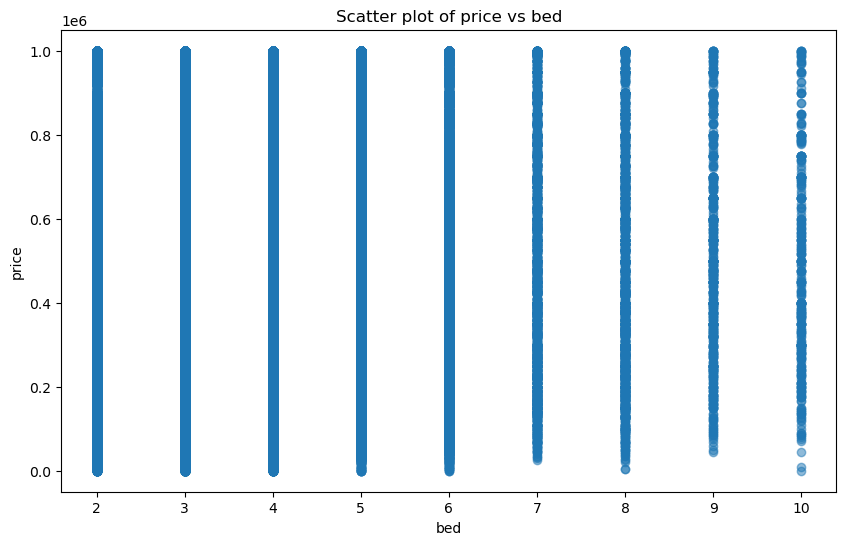

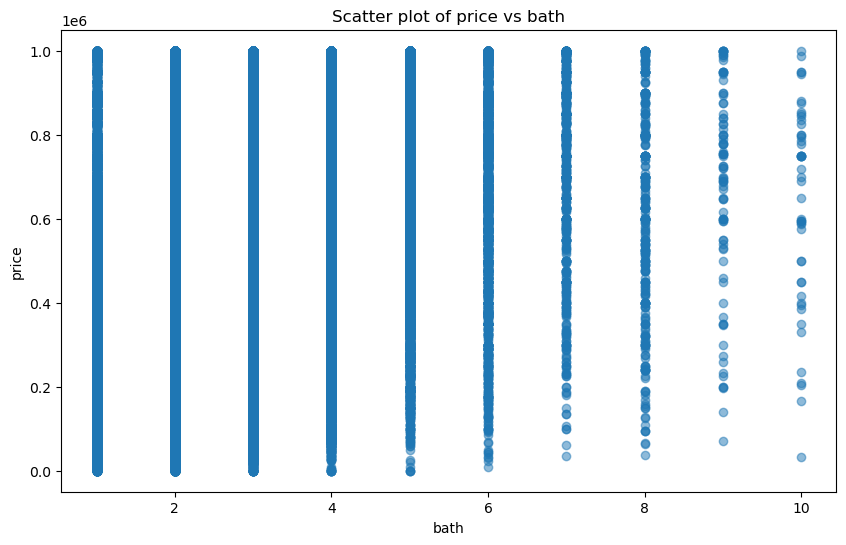

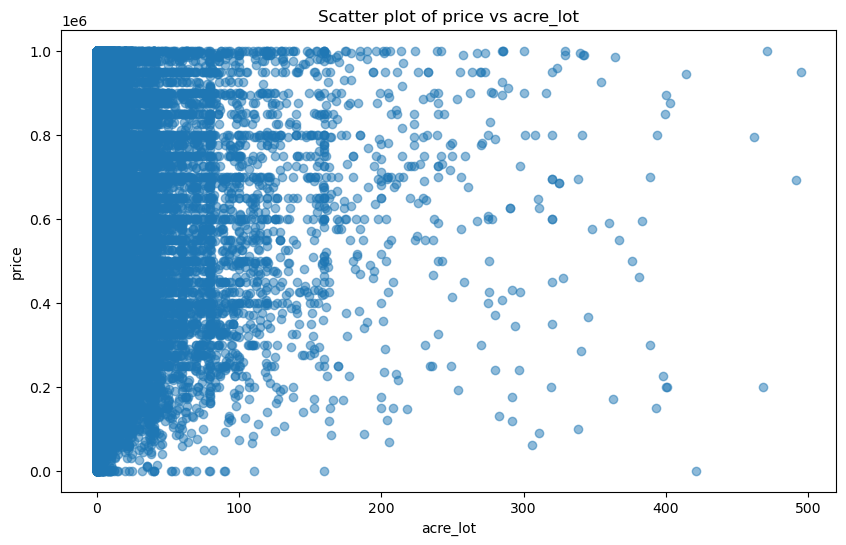

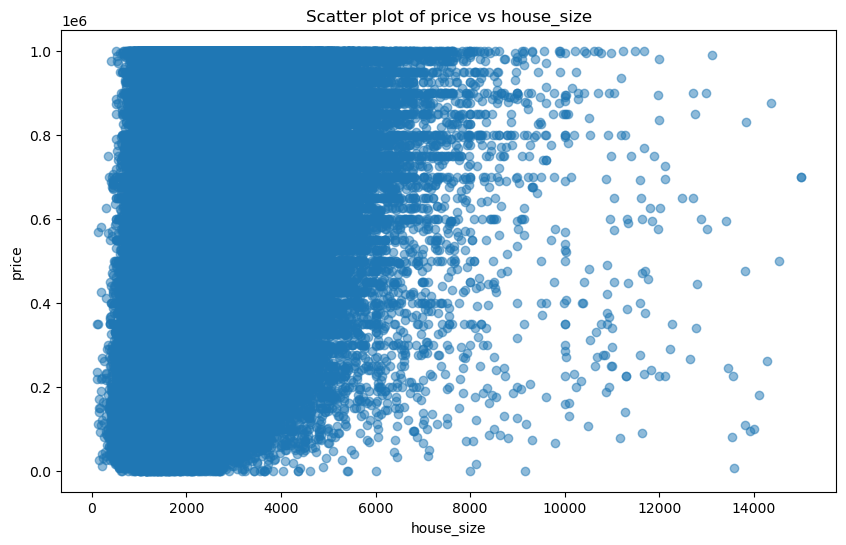


Fitting Linear Regression model for state: Puerto Rico
Mean Squared Error for state Puerto Rico: 28989979784.387653
R-squared for state Puerto Rico: 0.3397225703514407

Fitting Linear Regression model for state: Virgin Islands
Mean Squared Error for state Virgin Islands: 41487457732.86587
R-squared for state Virgin Islands: 0.5810952429851745

Fitting Linear Regression model for state: Massachusetts
Mean Squared Error for state Massachusetts: 38100441987.42688
R-squared for state Massachusetts: 0.2029013268620098

Fitting Linear Regression model for state: Connecticut
Mean Squared Error for state Connecticut: 22976574886.405945
R-squared for state Connecticut: 0.446376103666995

Fitting Linear Regression model for state: New Jersey
Mean Squared Error for state New Jersey: 25055316746.3867
R-squared for state New Jersey: 0.45360926502692656

Fitting Linear Regression model for state: New York
Mean Squared Error for state New York: 53050905881.408264
R-squared for state New York: 0.2042

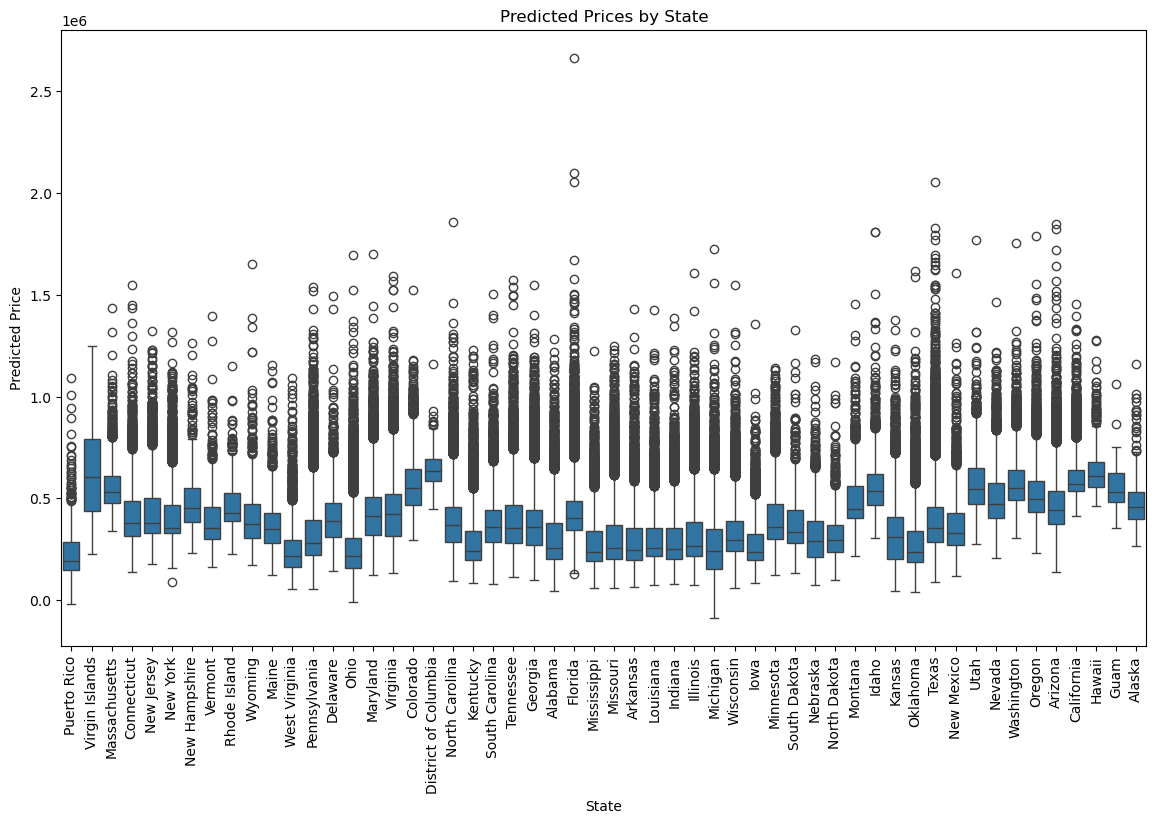

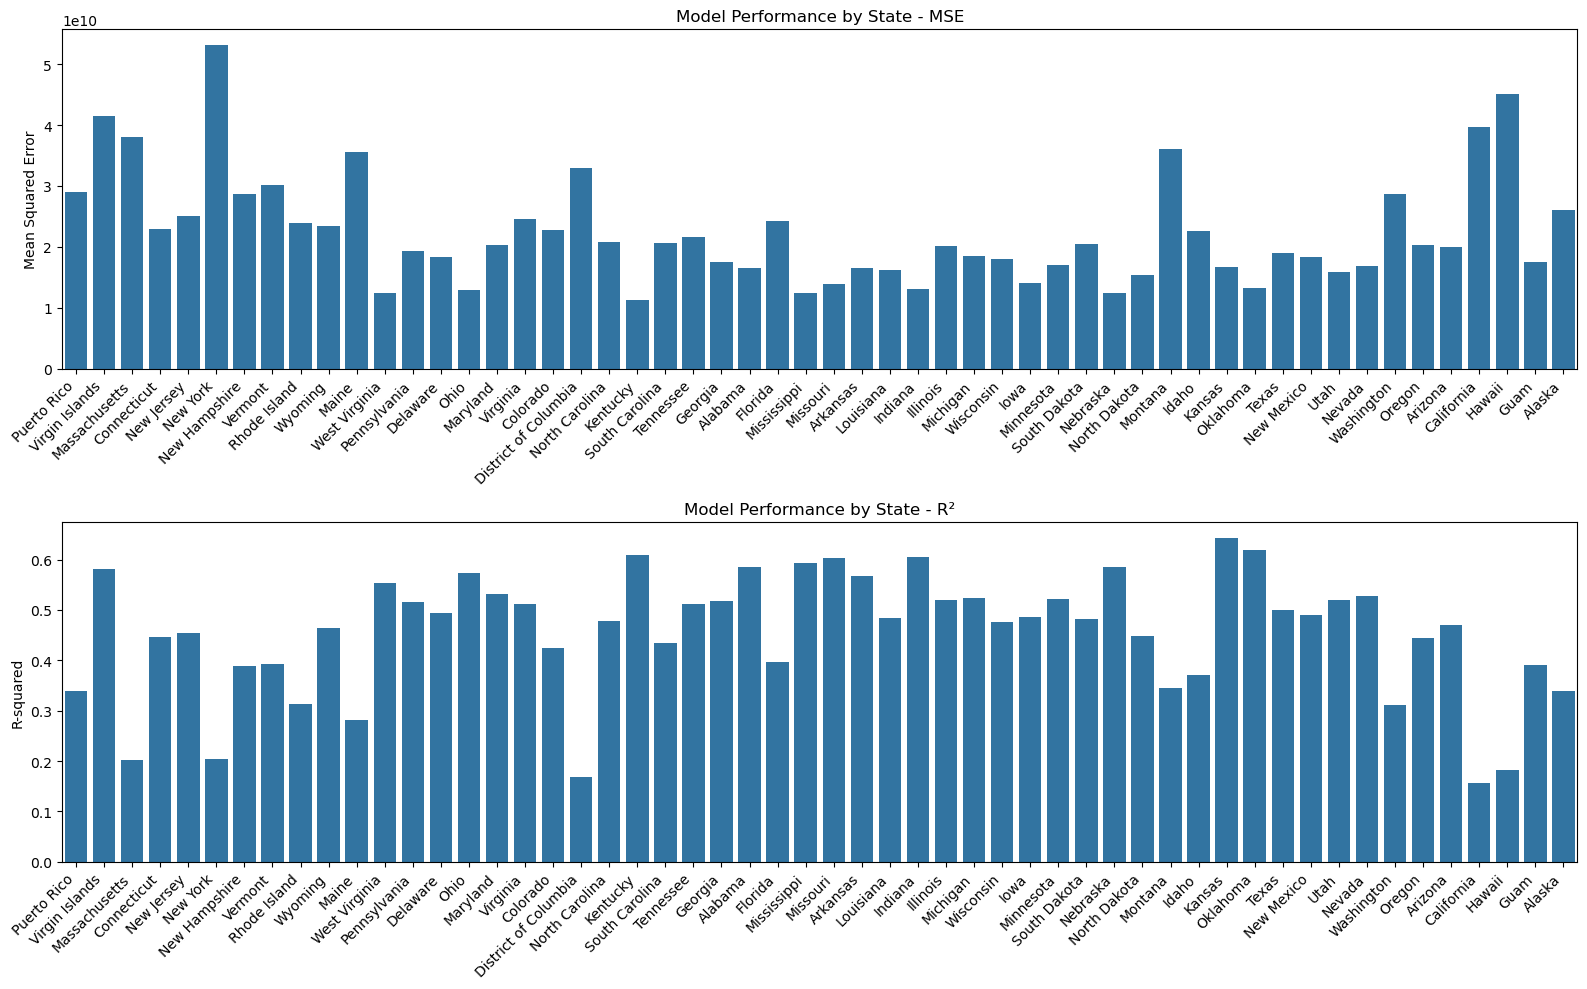


Statsmodels OLS Regression Results for California:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     2095.
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        00:41:16   Log-Likelihood:            -6.1189e+05
No. Observations:               44920   AIC:                         1.224e+06
Df Residuals:                   44915   BIC:                         1.224e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


/tmp/ipykernel_589/118442931.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  california_df['predicted_price'] = y_pred


In [4]:
### Main function to orchestrate the process
def main():
    df_cleaned = clean_data(df)

    features = ['bed', 'bath', 'acre_lot', 'house_size']
    target = 'price'

    # Remove properties with bedrooms > 20 (arbitrary threshold based on scatter plot)
    df_cleaned_no_extreme_data = df_cleaned[df_cleaned['bed'] <= 10]
    # Also remove bedrooms < 2
    df_cleaned_no_extreme_data = df_cleaned_no_extreme_data[df_cleaned_no_extreme_data['bed'] >= 2]
    # remove bathroom > 10
    df_cleaned_no_extreme_data = df_cleaned_no_extreme_data[df_cleaned_no_extreme_data['bath'] <= 10]
    # remove arc_lot > 12500
    df_cleaned_no_extreme_data = df_cleaned_no_extreme_data[df_cleaned_no_extreme_data['acre_lot'] <= 500]
    # remove house_size > 30000
    df_cleaned_no_extreme_data = df_cleaned_no_extreme_data[df_cleaned_no_extreme_data['house_size'] <= 15000]
    # Remove properties with prices > 10 million (arbitrary threshold based on scatter plot)
    df_cleaned_no_extreme_data = df_cleaned_no_extreme_data[df_cleaned_no_extreme_data['price'] <= 10**6]

    print(f"Number of observations after removing extreme outliers: {len(df_cleaned_no_extreme_data)}")

    # Re-plot the scatter plot to check if outliers are removed
    plot_relationship(df_cleaned_no_extreme_data, 'bed', 'price')

    # Plot relationships for other features
    plot_relationship(df_cleaned_no_extreme_data, 'bath', 'price')
    plot_relationship(df_cleaned_no_extreme_data, 'acre_lot', 'price')
    plot_relationship(df_cleaned_no_extreme_data, 'house_size', 'price')


    # Fit state models without extreme outliers
    state_models = fit_state_models(df_cleaned_no_extreme_data, features, target)
    print(state_models['California']['model'].coef_)

    # print_predicted_prices(state_models)
    
    # Show three examples of how the predict model works
    predicted_price = predict_price(state_models, 'California', 3, 2, 0.25, 2000)
    print(f"Predicted price for the house in California: ${predicted_price:.2f}")
    predicted_price = predict_price(state_models, 'Texas', 4, 3, 0.5, 3000)
    print(f"Predicted price for the house in Texas: ${predicted_price:.2f}")
    predicted_price = predict_price(state_models, 'Florida', 2, 1, 0.1, 1500)
    print(f"Predicted price for the house in Florida: ${predicted_price:.2f}")

    # Visualization 
    plot_predicted_prices_by_state(state_models)
    plot_model_performance(state_models)

    # Display regression results for California using statsmodels
    print("\nStatsmodels OLS Regression Results for California:")
    display_california_regression_results_sm(df_cleaned_no_extreme_data, features, target)

    # Display regression results for California using sklearn
    print("\nSklearn Linear Regression Results for California:")
    display_california_regression_results_sklearn(df_cleaned_no_extreme_data, features, target)

if __name__ == "__main__":
    main()